In [22]:
import pandas as pd
import re

# Load the Excel file
file_path = './RTVSlo/Podatki - PrometnoPorocilo_2022_2023_2024.xlsx'
data = pd.read_excel(file_path)

# Limit to the first 100 rows
data = data.head(10000)

# Function to remove HTML tags
def remove_html_tags(text):
    if isinstance(text, str):
        return re.sub(r'<[^>]*>', '', text)
    return text

# Process the data
processed_data = []
for index, row in data.iterrows():
    item = {}
    for column in data.columns:
        value = row[column]
        if pd.notna(value):  # Check if the cell is not empty
            item[column] = remove_html_tags(value)
    processed_data.append(item)

# Convert the processed data into a DataFrame
processed_df = pd.DataFrame(processed_data)

# Remove 'LegacyId' and 'Operater' columns if they exist
columns_to_remove = ['LegacyId', 'Operater']
processed_df = processed_df.drop(columns=[col for col in columns_to_remove if col in processed_df.columns])

# Save the processed data to a new Excel file (optional)
# processed_df.to_excel('./RTVSlo/Processed_Data_First_10000.xlsx', index=False)

processed_df.to_csv('./RTVSlo/Processed_Data_First_10000.csv', index=False)


In [23]:
# Importing pandas to check the number of rows in the file
import pandas as pd

# Load the Excel file
file_path = './RTVSlo/Podatki - PrometnoPorocilo_2022_2023_2024.xlsx'
data = pd.read_excel(file_path)

# Get the number of rows in the dataset
num_rows = data.shape[0]
num_rows


55001

In [27]:
import pandas as pd
import json

# Load the CSV file
file_path = './RTVSlo/Processed_Data_First_10000.csv'  # Adjust path if necessary
data = pd.read_csv(file_path)

# Set pandas options to prevent truncation of long text
pd.set_option('display.max_colwidth', None)  # This ensures that columns with long text are fully shown

# Initialize a list to store the processed rows
processed_data = []

# Iterate through each row in the DataFrame
for index, row in data.iterrows():
    row_dict = {}  # Dictionary to store non-NaN columns for the current row
    
    # Iterate through each column and check if it's not NaN
    for column, content in row.items():
        if pd.notna(content):  # Check if the content is not NaN
            row_dict[column] = content
    
    # Add the row dictionary to the processed data if it has any non-NaN values
    if row_dict:
        processed_data.append(row_dict)

# Save the processed data to a JSON file
json_file_path = './RTVSlo/Processed_Data_First_10000_non_nan.json'
with open(json_file_path, 'w', encoding='utf-8') as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=4)

# Print confirmation message
print(f"Processed data has been saved to {json_file_path}")


Processed data has been saved to ./RTVSlo/Processed_Data_First_10000_non_nan.json


In [26]:

# Count the number of non-NaN values in each column
non_nan_counts = data.notna().sum()

# Print the counts for each column
for column, count in non_nan_counts.items():
    print(f"{column}: {count}  values")

Datum: 10000  values
B1: 9999  values
ContentVremeSLO: 4771  values
TitleDeloNaCestiSLO: 9781  values
ContentDeloNaCestiSLO: 8478  values
TitleOpozorilaSLO: 4011  values
ContentOpozorilaSLO: 1490  values
ContentNesreceSLO: 3028  values
A1: 686  values
ContentPomembnoSLO: 686  values
ContentOvireSLO: 5303  values
ContentMednarodneInformacijeSLO: 6110  values
ContentZastojiSLO: 3520  values
TitleOvireSLO: 765  values
TitleSplosnoSLO: 4824  values
ContentSplosnoSLO: 3007  values
TitleVremeSLO: 3608  values
TitleZastojiSLO: 520  values
A2: 1  values
C2: 162  values
TitleNesreceSLO: 604  values


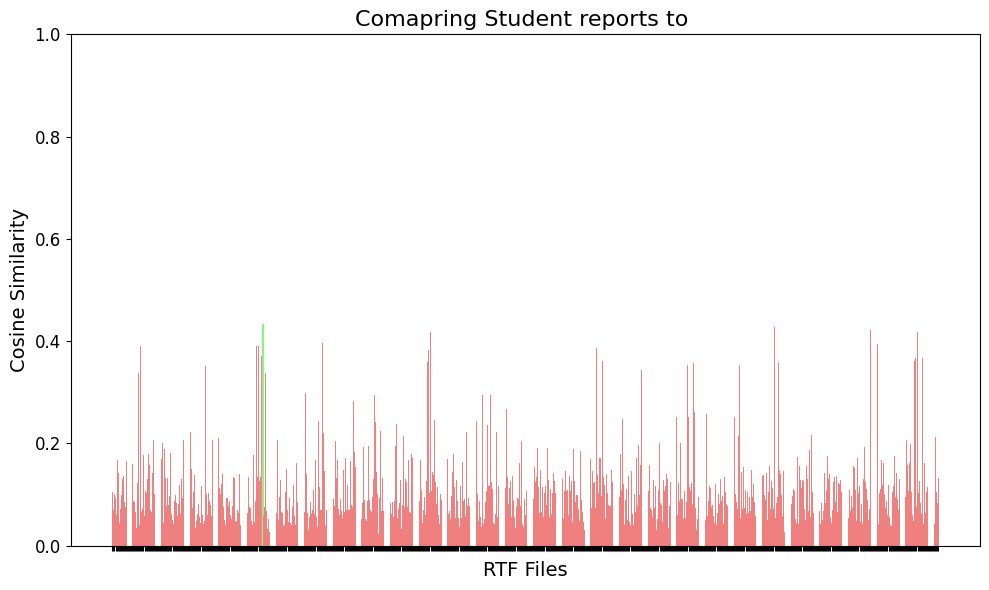

In [61]:
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from striprtf.striprtf import rtf_to_text
import matplotlib.pyplot as plt

# Function to load and read all rtf files in a directory
def load_rtf_files(directory):
    rtf_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".rtf"):
            file_path = os.path.join(directory, filename)
            with open(file_path, 'r') as file:
                rtf_content = file.read()
                text = rtf_to_text(rtf_content)  # Convert RTF to plain text
                # date = extract_date(text)  # Extract the third word as the date
                rtf_files.append((filename, text, rtf_content))  # Store the original RTF content too
    return rtf_files

# Preprocessing function to clean and tokenize text
def preprocess_text(text):
    # Remove special characters and digits, and make all lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    words = text.split()
    return ' '.join(words)

def extract_date(text):
    # Regular expression to match a date in the format DD. MM. YYYY
    date_pattern = r"\d{2}\.\s\d{2}\.\s\d{4}"
    
    # Search for the date pattern in the text
    date_match = re.search(date_pattern, text)
    print(date_match.group(0))
    
    if date_match:
        return date_match.group()  # Return the matched date
    else:
        return None  # Return None if no date is found

# Function to compute the cosine similarity between b1_contents and RTF contents
def compute_similarity(b1_contents, rtf_files):
    # Preprocess b1_contents
    b1_contents = preprocess_text(b1_contents)
    
    # Preprocess all RTF file contents
    rtf_texts = [(filename, preprocess_text(text), rtf_content) for filename, text, rtf_content in rtf_files]
    
    # Combine the texts: one for b1_contents and others for RTF files
    all_texts = [b1_contents] + [text for _, text, _ in rtf_texts]
    
    # Use TfidfVectorizer to vectorize the text data
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_texts)
    
    # Compute cosine similarity between b1_contents (first row) and all RTF file texts
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:])
    
    # Get similarity scores for each RTF file, including the original RTF content
    similarities = [(rtf_files[i][0], cosine_similarities[0][i], rtf_files[i][2]) for i in range(len(rtf_files))]
    
    # Sort by similarity score (highest first)
    # similarities.sort(key=lambda x: x[1], reverse=True)
    
    return similarities

# Directory path where the RTF files are located
directory = '/Users/petrakuralt/Desktop/mag 2.letnik/NLP/Project/github_project/ul-fri-nlp-course-project-2024-2025-jazbeci/RTVSlo/Podatki - rtvslo.si/Promet 2022/Marec 2022'

# Example of b1_contents, replace this with actual contents you want to compare
# b1_contents = "VremePonekod po Sloveniji gosta megla v pasovih zmanjšuje vidljivost. Prilagodite hitrost in varnostno razdaljo!Omejitve za tovorna vozilaOd 30. decembra je v veljavi sprememba omejitve za tovorna vozila nad 7,5 ton. Več."
# b1_contents = "ZastojiNa gorenjski avtocesti pred predorom Karavanke proti Avstriji, 1 kilometer. Za Kranjsko Goro uporabite izvoz Jesenice vzhod, Lipce. Popolna zapora cesteDo 14. uro bo na cesti Lipnica - Kropa - Železniki zaradi prireditve zaprt odsek Lajše - Rudno. Obvoz je na relaciji Rudno - Železniki - Selca - Lajše in obratno.Mejni prehodiČakalna doba je na mejnih prehodih Starod, Obrežje, Bistrica ob Sotli, Rogatec, Dobovec, Gruškovje, Zgornji Leskovec, Zavrč, Središče ob Dravi, Ormož in Petišovci.VremePrelaz Vršič je zaprt zaradi snega.Omejitev za tovorni prometDo 22. ure velja omejitev prometa tovornih vozil, katerih največja dovoljena masa presega 7,5 tone."
b1_contents = "DelaŠtajerska avtocesta bo zaprta med priključkoma Blagovica in Vransko proti Mariboru, do nedelje do 8. ure. Obvoz bo po regionalni cesti.Na primorski avtocesti bo promet potekal po enem prometnem pasu med Vrhniko in Brezovico proti Ljubljani predvidoma do nedelje do 16. ure.Do nedelje do 19. ure bo v Družinski vasi zaprta cesta Dolenje Kronovo - Dobrava.Na ljubljanski severni obvoznici sta zaprta uvoz Nove Jarše proti Zadobrovi in servisna cesta med Bratislavsko in Leskoškovo cesto. Obvoz je urejen preko Bratislavske in Letališke ceste do vzhodne obvoznice.PrireditveV nedeljo, med 12. in 17. uro, bodo občasne popolne zapore zaradi kolesarske prireditve: Izola - Sečovlje - Dragonja - Srgaši."
rtf_files = load_rtf_files(directory)

# Compute similarity
similar_files = compute_similarity(b1_contents, rtf_files)
# Compute similarity

# Extract filenames and similarity scores before sorting
filenames_before_sort = [file[0] for file in similar_files]
similarity_scores_before_sort = [file[1] for file in similar_files]

plt.figure(figsize=(10, 6))
bars = plt.bar(filenames_before_sort, similarity_scores_before_sort, color='lightcoral')

# Highlight the max similarity bar
max_similarity_index = similarity_scores_before_sort.index(max(similarity_scores_before_sort))
bars[max_similarity_index].set_color('lightgreen')  # Color the bar with max similarity

# Labeling the plot
plt.ylabel('Cosine Similarity', fontsize=14)
plt.xlabel('RTF Files', fontsize=14)
plt.title('Comapring Student reports to ', fontsize=16)
plt.ylim(0, 1)  # Cosine similarity ranges from 0 to 1

# Rotate x-axis labels and make them bigger
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Remove x-axis labels
plt.gca().set_xticklabels([])

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('cosine_similarity_plot.png')

# Display the plot
plt.show()

# Now sort the similarities by similarity score
similar_files.sort(key=lambda x: x[1], reverse=True)


# Display the most similar files with their content
# print("Most similar RTF files to b1_contents:")
# for filename, similarity, full_rtf in similar_files:
#     print(f"Filename: {filename}\nSimilarity: {similarity:.4f}")
#     print("RTF File Content (First 500 characters):")
#     print(full_rtf[:500])  # Displaying the first 500 characters of the RTF file
#     print("\n---\n")




rtf_text: Prometne informacije          02. 04. 2022       13.00        1. in 3. program

Podatki o prometu.

Na gorenjski avtocesti je zaradi pokvarjenega vozila oviran promet pred priključkom Brnik proti Karavankam.   

Zaradi del je na avtocestnem odseku od Maribora proti Šentilju promet med razcepom Dragučova in krožiščem Pesnica urejen le po polovici avtoceste.
 
{'Datum': '2022-01-01 00:07:07', 'B1': 'VremePonekod po Sloveniji megla v pasovih zmanjšuje vidljivost. Prilagodite hitrost!Omejitve za tovorna vozilaPo Sloveniji velja med prazniki omejitev za tovorna vozila z največjo dovoljeno maso nad 7,5 ton:- v soboto, 1. 1., od 8. do 22. ure;- v nedeljo, 2. 1., od 8. do 22. ure.Od 30. decembra je v veljavi sprememba omejitve za tovorna vozila nad 7,5 ton. Več.DelaNa primorski avtocesti je ponovno odprt priključek Črni Kal v obe smeri.', 'ContentVremeSLO': 'Ponekod po Sloveniji megla v pasovih zmanjšuje vidljivost. Prilagodite hitrost!', 'TitleDeloNaCestiSLO': 'Dela', 'ContentDeloNa

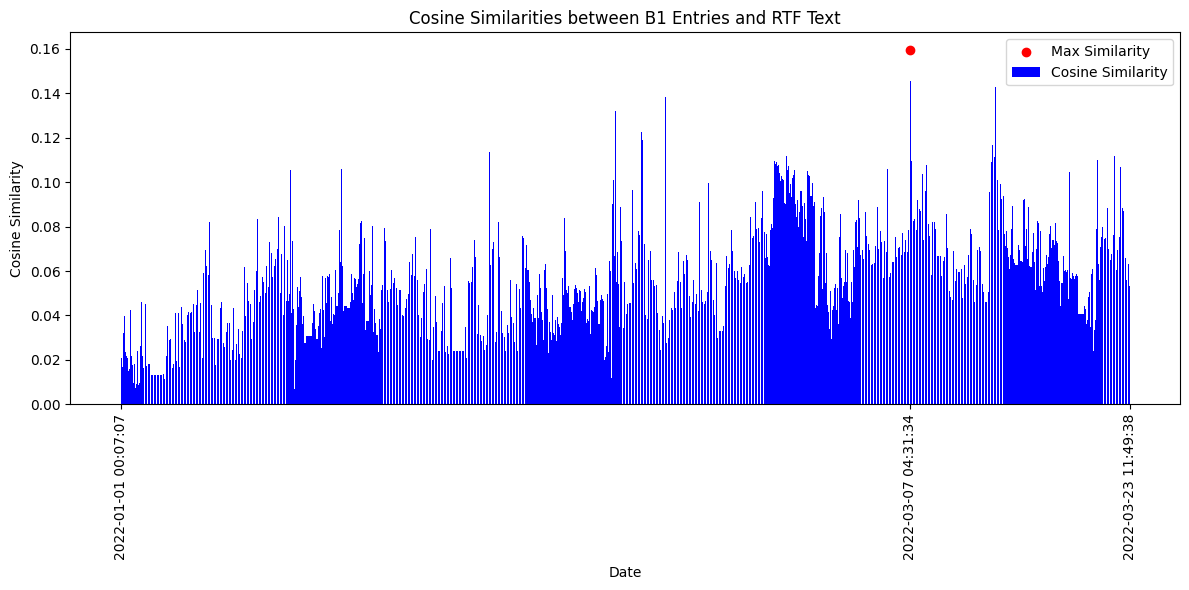

In [77]:
import json
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from striprtf.striprtf import rtf_to_text

# Function to load the JSON data
def load_json_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

# Function to load the RTF text file
def load_rtf_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        rtf_data = f.read()
    return rtf_to_text(rtf_data)

# Function to preprocess the text (remove special characters and lowercasing)
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
    return text.lower()

# Function to compute cosine similarity
def compute_cosine_similarity(b1_texts, rtf_text):
    # Preprocess both B1 texts and RTF text
    processed_b1 = [preprocess_text(b1) for b1 in b1_texts]
    processed_rtf = preprocess_text(rtf_text)
    
    # Combine the texts (B1 entries + RTF text) for vectorization
    texts = processed_b1 + [processed_rtf]
    
    # Create TF-IDF Vectorizer
    vectorizer = TfidfVectorizer()
    
    # Fit and transform the texts
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Compute cosine similarity between each B1 entry and the RTF text
    cosine_similarities = cosine_similarity(tfidf_matrix[:-1], tfidf_matrix[-1:])
    
    return cosine_similarities.flatten()

# Example usage
json_file_path = "/Users/petrakuralt/Desktop/mag 2.letnik/NLP/Project/github_project/ul-fri-nlp-course-project-2024-2025-jazbeci/RTVSlo/Processed_Data_First_10000_non_nan.json"
rtf_file_path = '/Users/petrakuralt/Desktop/mag 2.letnik/NLP/Project/github_project/ul-fri-nlp-course-project-2024-2025-jazbeci/RTVSlo/Podatki - rtvslo.si/Promet 2022/April 2022/TMP-700.rtf'


# Load data
json_data = load_json_data(json_file_path)
rtf_text = load_rtf_text(rtf_file_path)
print("rtf_text:",rtf_text)
print(json_data[0])
# Extract B1 text from the JSON data (for the first 10000 entries, adjust as necessary)
b1_texts = [entry['B1'] for entry in json_data[:10000] if 'B1' in entry]
# Compute cosine similarities
cosine_similarities = compute_cosine_similarity(b1_texts, rtf_text)

# Show the cosine similarities for each B1 entry
for idx, similarity in enumerate(cosine_similarities[:10]):  # Displaying the first 10 for brevity
    print(f"Cosine Similarity for entry {idx+1}: {similarity:.4f}")


dates = [entry['Datum'] for entry in json_data[:10000] if 'B1' in entry]

import matplotlib.pyplot as plt

# Assuming cosine_similarities is computed, and you have the dates from the JSON data

# Plot the cosine similarities as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(dates, cosine_similarities, color='blue', label="Cosine Similarity")

# Highlight the maximum similarity with a red dot
max_similarity_idx = cosine_similarities.argmax()

max_similarity_entry = json_data[:10000][max_similarity_idx]
print("Max similarity json:", max_similarity_entry)
plt.scatter(dates[max_similarity_idx], cosine_similarities[max_similarity_idx], color='red', label="Max Similarity", zorder=5)

# Label the first, last, and max similarity date
plt.xticks([dates[0], dates[-1], dates[max_similarity_idx]], 
           [dates[0], dates[-1], dates[max_similarity_idx]])

# Rotate date labels for better visibility
plt.xticks(rotation=90)

# Adding title and labels
plt.title("Cosine Similarities between B1 Entries and RTF Text")
plt.xlabel("Date")
plt.ylabel("Cosine Similarity")
plt.legend()

plt.tight_layout()  # To prevent clipping of the x-axis labels
plt.show()


RTF FILE DATE: Prometne informacije        06. 04. 2022       13.00         1. in  2. program

max sim: 2022-01-01 00:07:07

In [74]:
# Retrieve the JSON entry corresponding to the max similarity
max_similarity_entry = json_data[:10000][max_similarity_idx]

max_similarity_entry


{'Datum': '2022-03-03 14:11:19',
 'B1': 'OvireNa primorski avtocesti je zaradi okvare tovornega vozila oviran promet pred počivališčem Ravbarkomanda proti Kopru.Na štajerski avtocesti je zaradi okvare vozila oviran promet pred izvozom Trojane proti Mariboru.Mejni prehodiČakalna doba je na mejnem prehodu Gruškovje.DelaNa gorenjski avtocesti bo promet skozi predor Karavanke urejen izmenično enosmerno s čakanjem pred predorom 30 minut, med 8. in 16. uro: 3., 6., 8., 9. in 10. marca.Na primorski avtocesti bo do konca marca, promet med razcepom Srmin in priključkom Črni Kal potekal po enem pasu v vsako smer. Zaprt je razcep Srmin iz smeri Škofij proti Ljubljani ter priključek Luka Koper. Obvoz iz smeri Škofij proti Ljubljani je preko priključka Bertoki.',
 'TitleDeloNaCestiSLO': 'Dela',
 'ContentDeloNaCestiSLO': 'Na gorenjski avtocesti bo promet skozi predor Karavanke urejen izmenično enosmerno s čakanjem pred predorom 30 minut, med 8. in 16. uro: 3., 6., 8., 9. in 10. marca.Na primorski av

In [82]:
import os
from striprtf.striprtf import rtf_to_text

def find_files_with_word(directory, word):
    # Dictionary to store the filename as the key and the file's content as the value
    matching_files = {}
    
    for filename in os.listdir(directory):
        if filename.endswith('.rtf'):
            file_path = os.path.join(directory, filename)
            try:
                # Open and read the RTF file
                with open(file_path, 'r', encoding='latin1') as file:
                    rtf_content = file.read()
                    
                    # Convert RTF content to plain text
                    text_content = rtf_to_text(rtf_content)
                    
                    # Check if the word "prireditve" is in the text
                    if word.lower() in text_content.lower():
                        matching_files[filename] = text_content  # Add filename as key and content as value
            except Exception as e:
                print(f"Error reading {filename}: {e}")
    
    return matching_files

# Example usage:
directory = '/Users/petrakuralt/Desktop/mag 2.letnik/NLP/Project/github_project/ul-fri-nlp-course-project-2024-2025-jazbeci/RTVSlo/Podatki - rtvslo.si/Promet 2022/Januar 2022'  # Replace with the directory path
word_to_find = 'prireditve'

matching_files = find_files_with_word(directory, word_to_find)

if matching_files:
    print("Files containing the word 'prireditve':")
    for filename, content in matching_files.items():  # Iterate through the dictionary
        print(f"\n\n--- File: {filename} ---\n")
        print(content)  # Print the entire content of the file
else:
    print("No files found containing the word 'prireditve'.")


Files containing the word 'prireditve':


--- File: TMP-597.rtf ---

Prometne informacije       09. 01. 2022       12.00                1. in 3. program 

Podatki o prometu.

Pred predorom Karavanke je kilometer dolg zastoj proti Avstriji.

Do 14-ih bo na cesti Lipnica-Kropa-Železniki zaradi prireditve zaprt odsek Lajše-Rudno.

Na mejnih prehodih Gruškovje, Obrežje in Zgornji Leskovec vozniki osebnih vozil na vstop v državo čakajo do 2 uri, v Dobovcu, Zavrču, in Ormožu do 1 uro, v Središču ob Dravi pa do pol ure. V Gruškovju je prav tako pri vstopu povečan promet avtobusov.
 


--- File: TMP-594.rtf ---

Prometne informacije       09. 01. 2022       13.30                2. program 

Podatki o prometu.

Pred predorom Karavanke je kilometer dolg zastoj proti Avstriji.

Do 14-ih bo na cesti Lipnica-Kropa-Železniki zaradi prireditve zaprt odsek Lajše-Rudno.

Na mejnem prehodu Gruškovje vozniki osebnih vozil na vstop v državo čakajo 2 uri, na Obrežju, Dobovcu in Zgornjem Leskovcu pa do 2 ur